In [9]:
import torch
import pickle
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_config import line_colors, lr_line_style, zs_line_style,ccs_line_style, num_hidden_layers,layers_arr

In [10]:
num_hidden_layers = 40
layers_arr = np.arange(num_hidden_layers)

In [11]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = pickle.load(open(layer_path, "rb"))
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str):
    
    for reporter,path in zip(['ccs','vinc','lr'], [ccs_path,vinc_path,lr_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    

def similarity(rep1_normalized, rep2_normalized):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim


def similarity_single_layer(rep1_normalized, rep1_layer: int, rep2_normalized):
    cosine_sim = torch.einsum("j,ij->i", rep1_normalized[rep1_layer], rep2_normalized)
    return cosine_sim

## test-llama branch

In [12]:
data = {}

for d in [0,10,30,50]:


    dataset = f"imdb_misspelled_{d}"

    lr_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/lr_models'
    ccs_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/reporters'
    vinc_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path)

In [13]:
sim = {}

for d in [0,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    sim[(dataset, 'lr-vinc')] = similarity(data[(dataset,'lr')], data[(dataset,'vinc')])
    sim[(dataset, 'lr-ccs')] = similarity(data[(dataset,'lr')], data[(dataset,'ccs')])
    sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])
    sim[(dataset, f'lr-0-{d}')] = similarity(data[("imdb_misspelled_0",'lr')], data[(dataset,'lr')])
    sim[(dataset, f'ccs-0-{d}')] = similarity(data[('imdb_misspelled_0','ccs')], data[(dataset,'ccs')])
    sim[(dataset, f'vinc-0-{d}')] = similarity(data[('imdb_misspelled_0','vinc')], data[(dataset,'vinc')])
    sim[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data[(dataset,'vinc')],20,data[(dataset,'vinc')])
    sim[(dataset, f'ccs-{d}-layer20')] = similarity_single_layer(data[(dataset,'ccs')],20,data[(dataset,'ccs')])
    sim[(dataset, f'lr-{d}-layer20')] = similarity_single_layer(data[(dataset,'lr')],20,data[(dataset,'lr')])

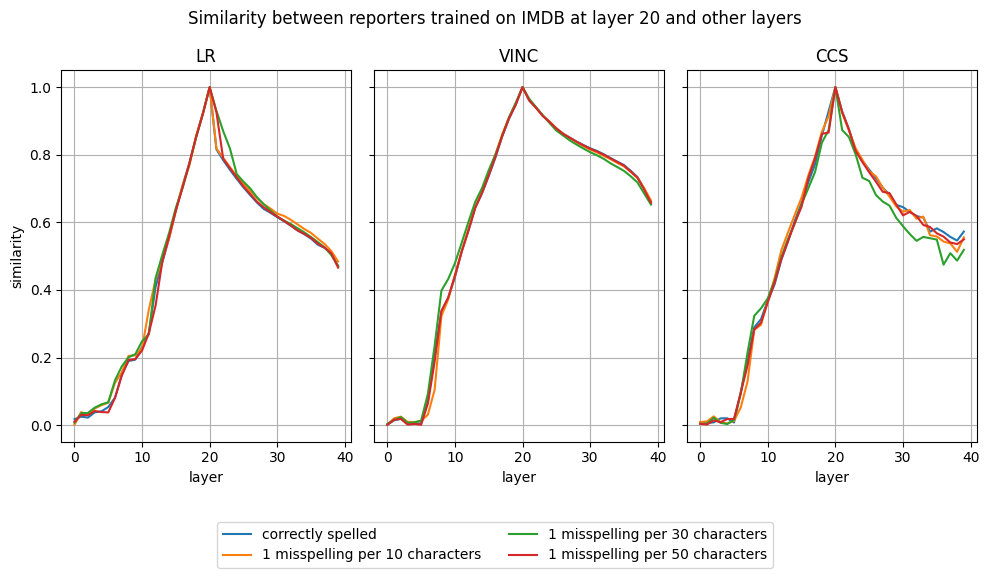

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained on IMDB at layer 20 and other layers")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = f"1 misspelling per {d} characters")


handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=2) 

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = f"1 misspelling per {d} characters")


ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = f"1 misspelling per {d} characters")

plt.tight_layout()
plt.show()

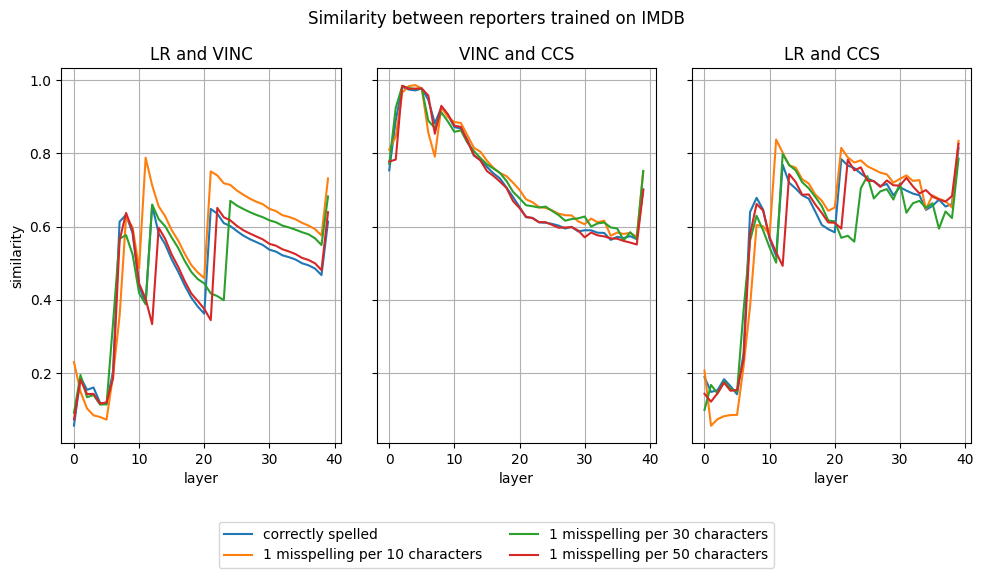

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained on IMDB")

ax = axs[0]
ax.set_title(fr"LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = f"1 misspelling per {d} characters")

                
handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=1) 

ax = axs[1]
ax.set_title(fr"VINC and CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f"1 misspelling per {d} characters")

ax = axs[2]
ax.set_title(fr"LR and CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-ccs')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-ccs')]), label = f"1 misspelling per {d} characters")

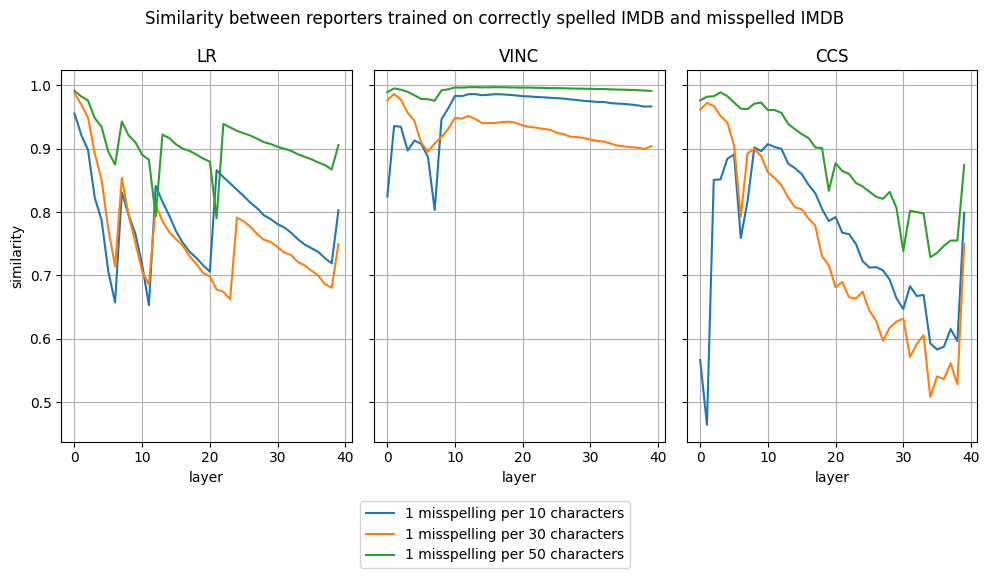

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained on correctly spelled IMDB and misspelled IMDB")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-0-{d}')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-0-{d}')]), label = f"1 misspelling per {d} characters")

handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=1) 

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in [10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-0-{d}')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-0-{d}')]), label = f"1 misspelling per {d} characters")

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)
for d in [10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-0-{d}')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-0-{d}')]), label = f"1 misspelling per {d} characters")

plt.tight_layout()
plt.show()

## arithmetic branch

In [38]:
data2 = {}

for d in [0,5,10,30,50]:

    dataset = f"imdb_misspelled_{d}"

    lr_path = f'/home/waree/elk-reporters/arith-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/lr_models'
    ccs_path = f'/home/waree/elk-reporters/arith-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/reporters'
    lr2_path = f'/home/waree/elk-reporters/arith-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/lr_models'
    vinc_path = f'/home/waree/elk-reporters/arith-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/reporters'

    get_norm_weights(data2, dataset, ccs_path, vinc_path, lr_path, lr2_path)

In [51]:
sim2 = {}

for d in [0,5,10,30,50]:

    dataset = f"imdb_misspelled_{d}"

    sim2[(dataset, 'lr-lr2')] = similarity(data2[(dataset,'lr')], data2[(dataset,'lr2')])
    sim2[(dataset, 'lr-ccs')] = similarity(data2[(dataset,'lr')], data2[(dataset,'ccs')])
    sim2[(dataset, 'lr-vinc')] = similarity(data2[(dataset,'lr')], data2[(dataset,'vinc')])
    sim2[(dataset, 'lr2-ccs')] = similarity(data2[(dataset,'lr2')], data2[(dataset,'ccs')])
    sim2[(dataset, 'lr2-vinc')] = similarity(data2[(dataset,'lr2')], data2[(dataset,'vinc')])
    sim2[(dataset, 'ccs-vinc')] = similarity(data2[(dataset,'ccs')], data2[(dataset,'vinc')])
    sim2[(dataset, f'lr-0-{d}')] = similarity(data2[('imdb_misspelled_0','lr')], data2[(dataset,'lr')])
    sim2[(dataset, f'vinc-0-{d}')] = similarity(data2[('imdb_misspelled_0','vinc')], data2[(dataset,'vinc')])
    sim2[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data2[(dataset,'vinc')],20,data2[(dataset,'vinc')])
    sim2[(dataset, f'lr-{d}-layer20')] = similarity_single_layer(data2[(dataset,'lr')],20,data2[(dataset,'lr')])

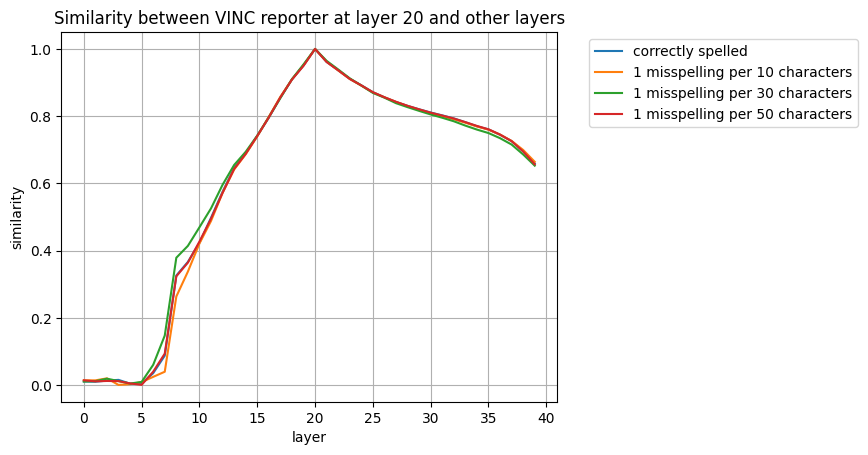

In [52]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'vinc-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'vinc-{d}-layer20')]), label = f"1 misspelling per {d} characters")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

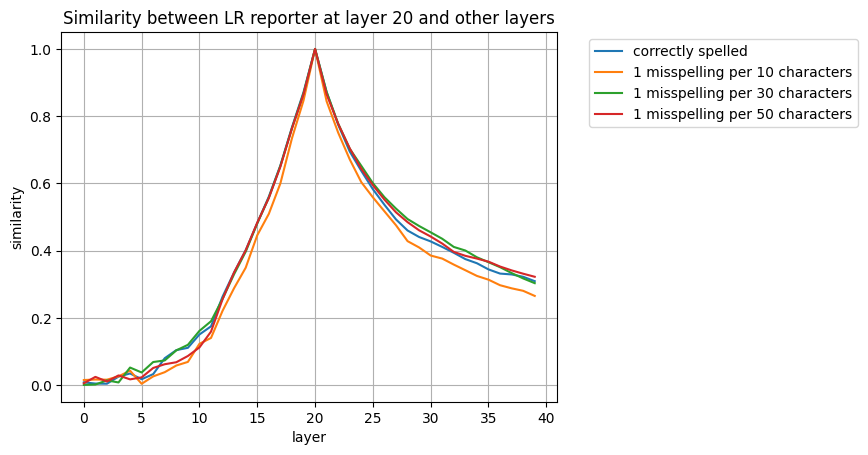

In [53]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'lr-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'lr-{d}-layer20')]), label = f"1 misspelling per {d} characters")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

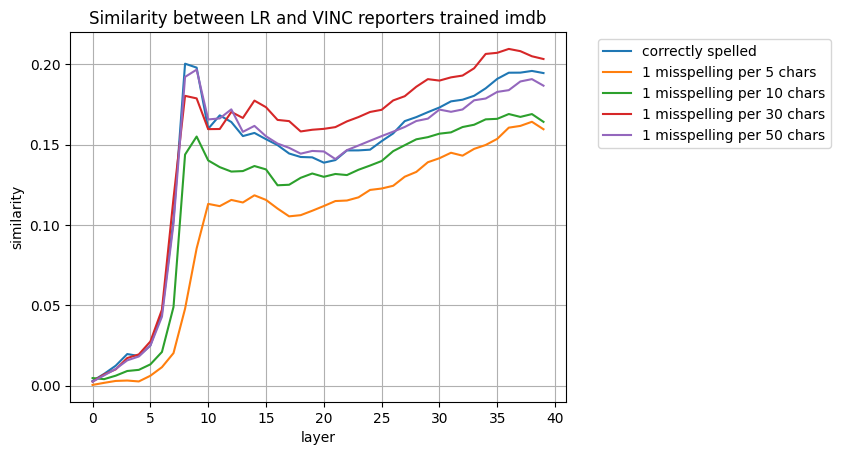

In [34]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR and VINC reporters trained IMDB")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)


for d in [0,5,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.abs(sim2[(dataset, 'lr-vinc')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.abs(sim2[(dataset, 'lr-vinc')]), label = f"1 misspelling per {d} chars")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

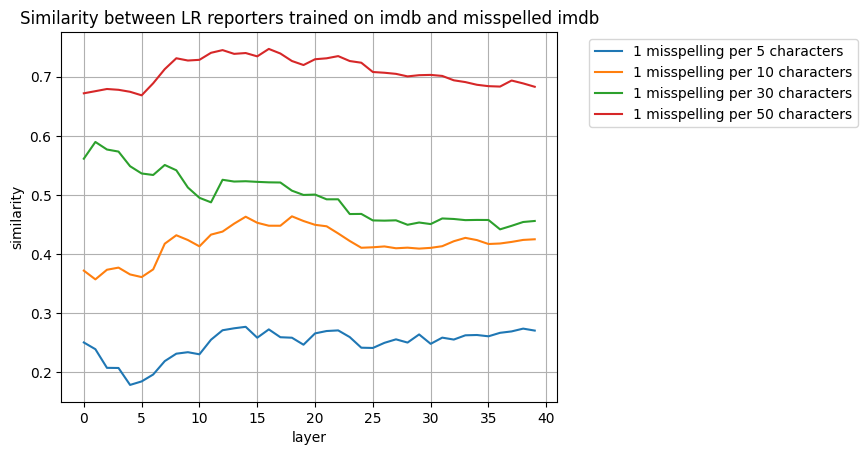

In [35]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporters trained on IMDB and misspelled IMDB")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'lr-0-{d}')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'lr-0-{d}')]), label = f"1 misspelling per {d} characters")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

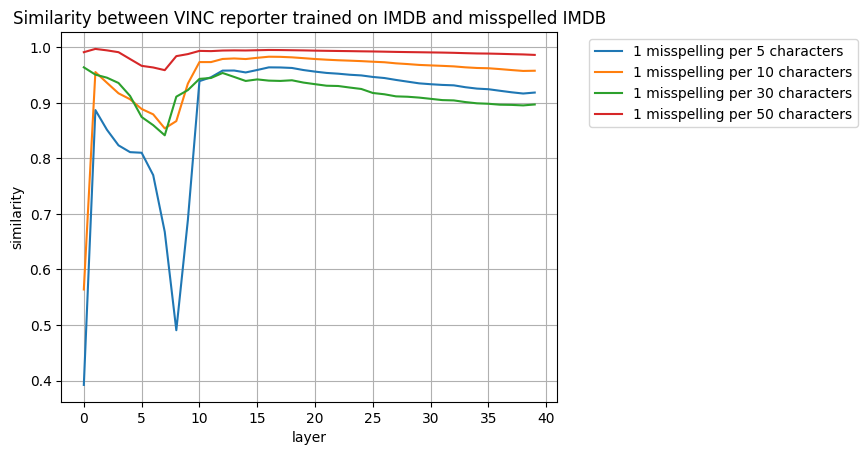

In [39]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter trained on IMDB and misspelled IMDB")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'vinc-0-{d}')]), label = f"correctly spelled")

    else:

        ax.plot(layers_arr, np.absolute(sim2[(dataset, f'vinc-0-{d}')]), label = f"1 misspelling per {d} characters")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [56]:
sim3 = {}

for d in [0,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    sim3[(dataset, 'vinc-vinc')] = similarity(data[(dataset,'vinc')], data2[(dataset,'vinc')])

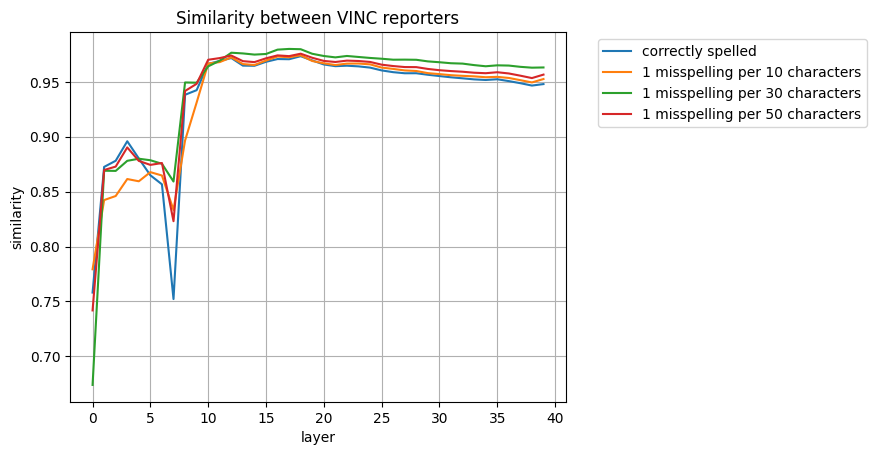

In [57]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporters")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim3[(dataset, f'vinc-vinc')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim3[(dataset, f'vinc-vinc')]), label = f"1 misspelling per {d} characters")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()